<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/Lecture_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook illustrating Gradient Descent
## Created by Daniel Newman, https://github.com/dtnewman
### From: https://nbviewer.jupyter.org/github/dtnewman/gradient_descent/blob/master/stochastic_gradient_descent.ipynb
### Modified by James Green, Sept 2019

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.optimize import fmin

### Gradient Descent

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha_k s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [0]:
f = lambda x: x**3-2*x**2+2

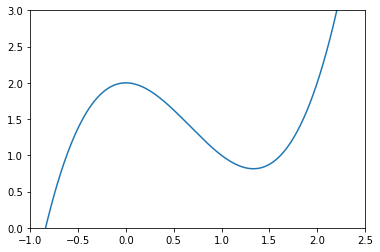

In [3]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

We can see from plot above that our local minimum is gonna be near around 1.4 or 1.5 (on the x-axis), but let's pretend that we don't know that, so we set our starting point (arbitrarily, in this case) at $x_0 = 2$

In [4]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = -f_prime(x_old)
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f(x_new))
print('Local minimum occurs at: {:.3f}'.format(x_new))
print("Number of steps:", len(x_list))

Local minimum occurs at: 1.333
Number of steps: 17


The figures below show the route that was taken to find the local minimum.

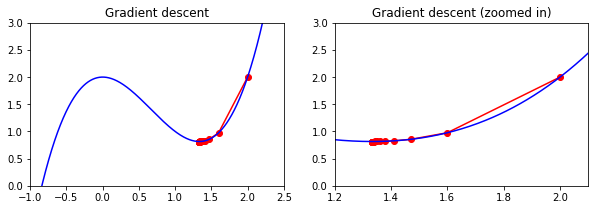

In [0]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([0,3])
plt.title("Gradient descent (zoomed in)")
plt.show()

You'll notice that the step size (also called learning rate) in the implementation above is constant. Doing this makes it easier to implement the algorithm. However, it also presents some issues: If the step size is too small, then convergence will be very slow, but if we make it too large, then the method may fail to converge at all. 

A solution to this is to update the step size is choosing a decrease constant $d$ that shrinks the step size over time:
$\eta(t+1) = \eta(t) / (1+t \times d)$.

In [0]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.17 # step size
precision = 0.0001
t, d = 0, 1

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = -f_prime(x_old)
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f(x_new))
    n_k = n_k / (1 + t * d)
    t += 1

print('Local minimum occurs at: {:.3f}'.format(x_new))
print("Number of steps:", len(x_list))

Local minimum occurs at: 1.331
Number of steps: 6


Let's now consider an example which is a little bit more complicated. Consider a simple **linear regression** where we want to see how the temperature affects the noises made by crickets. We have a data set of cricket chirp rates at various temperatures. First we'll load that data set in and plot it:

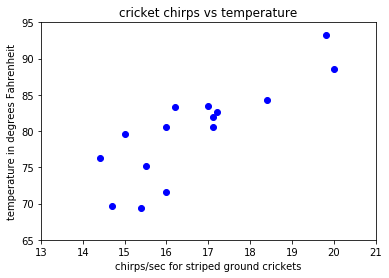

In [0]:
#Load the dataset
#data = np.loadtxt('SGD_data.txt', delimiter=',')
data = np.loadtxt('https://github.com/dtnewman/gradient_descent/raw/master/SGD_data.txt', delimiter=',') #Using "raw" URL from github repository
 
#Plot the data
plt.scatter(data[:, 0], data[:, 1], marker='o', c='b')
plt.title('cricket chirps vs temperature')
plt.xlabel('chirps/sec for striped ground crickets')
plt.ylabel('temperature in degrees Fahrenheit')
plt.xlim([13,21])
plt.ylim([65,95])
plt.show()

Our goal is to find the equation of the straight line $h_\theta(x) = \theta_0 + \theta_1 x$ that best fits our data points. The function that we are trying to minimize in this case is:

$J(\theta_0,\theta_1) = {1 \over 2m} \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)^2$

In this case, our gradient will be defined in two dimensions:

$\frac{\partial}{\partial \theta_0} J(\theta_0,\theta_1) = \frac{1}{m}  \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)$

$\frac{\partial}{\partial \theta_1} J(\theta_0,\theta_1) = \frac{1}{m}  \sum\limits_{i=1}^m ((h_\theta(x_i)-y_i) \cdot x_i)$

Below, we set up our function for h, J and the gradient:

In [0]:
h = lambda theta_0,theta_1,x: theta_0 + theta_1*x

def J(x,y,m,theta_0,theta_1):
    returnValue = 0
    for i in range(m):
        returnValue += (h(theta_0,theta_1,x[i])-y[i])**2
    returnValue = returnValue/(2*m)
    return returnValue

def grad_J(x,y,m,theta_0,theta_1):
    returnValue = np.array([0.,0.])
    for i in range(m):
        returnValue[0] += (h(theta_0,theta_1,x[i])-y[i])
        returnValue[1] += (h(theta_0,theta_1,x[i])-y[i])*x[i]
    returnValue = returnValue/(m)
    return returnValue

Now, we'll load our data into the x and y variables;

In [0]:
x = data[:, 0]
y = data[:, 1]
m = len(x)

And we run our gradient descent algorithm (without adaptive step sizes in this example):

In [0]:
theta_old = np.array([0.,0.])
theta_new = np.array([1.,1.]) # The algorithm starts at [1,1]
n_k = 0.001 # step size
precision = 0.001
num_steps = 0
s_k = float("inf")

while np.linalg.norm(s_k) > precision:
    num_steps += 1
    theta_old = theta_new
    s_k = -grad_J(x,y,m,theta_old[0],theta_old[1])
    theta_new = theta_old + n_k * s_k

print("Local minimum occurs where:")
print('theta_0 = {:.3f}'.format(theta_new[0]))
print('theta_1 = {:.3f}'.format(theta_new[1]))
print("This took",num_steps,"steps to converge")

Local minimum occurs where:
theta_0 = 25.129
theta_1 = 3.297
This took 565859 steps to converge


For comparison, let's get the actual values for $\theta_0$ and $\theta_1$:

In [0]:
actualvalues = sp.stats.linregress(x,y)
print("Actual values for theta (using built-in linear regression) are:")
print('theta_0 = {:.3f}'.format(actualvalues.intercept))
print('theta_1 = {:.3f}'.format(actualvalues.slope))


Actual values for theta (using built-in linear regression) are:
theta_0 = 25.232
theta_1 = 3.291


So we see that our values are relatively close to the actual values (even though our method was pretty slow). If you look at the source code of [linregress](https://github.com/scipy/scipy/blob/master/scipy/stats/_stats_mstats_common.py), it uses the convariance matrix of x and y to compute fastly. Below, you can see a plot of the line drawn with our theta values against the data:

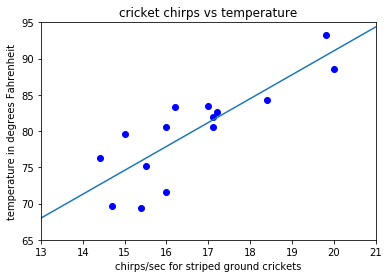

In [0]:
xx = np.linspace(0,21,1000)
plt.scatter(data[:, 0], data[:, 1], marker='o', c='b')
plt.plot(xx,h(theta_new[0],theta_new[1],xx))
plt.xlim([13,21])
plt.ylim([65,95])
plt.title('cricket chirps vs temperature')
plt.xlabel('chirps/sec for striped ground crickets')
plt.ylabel('temperature in degrees Fahrenheit')
plt.show()

Notice that in the method above we need to calculate the gradient in every step of our algorithm. In the example with the crickets, this is not a big deal since there are only 15 data points. But imagine that we had 10 million data points. If this were the case, it would certainly make the method above far less efficient.

In machine learning, the algorithm above is often called <b>batch gradient descent</b> to contrast it with <b>mini-batch gradient descent</b> (which we will not go into here) and <b>stochastic gradient descent</b>.

### Stochastic gradient descent

As we said above, in batch gradient descent, we must look at every example in the entire training set on every step (in cases where a training set is used for gradient descent). This can be quite slow if the training set is sufficiently large. In <b>stochastic gradient descent</b>, we update our values after looking at <i>each</i> item in the training set, so that we can start making progress right away. Recall the linear regression example above. In that example, we calculated the gradient for each of the two theta values as follows:

$\frac{\partial}{\partial \theta_0} J(\theta_0,\theta_1) = \frac{1}{m}  \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)$

$\frac{\partial}{\partial \theta_1} J(\theta_0,\theta_1) = \frac{1}{m}  \sum\limits_{i=1}^m ((h_\theta(x_i)-y_i) \cdot x_i)$

Where $h_\theta(x) = \theta_0 + \theta_1 x$

Then we followed this algorithm (where $\alpha$ was a non-adapting stepsize):

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>

When the sample data had 15 data points as in the example above, calculating the gradient was not very costly. But for very large data sets, this would not be the case. So instead, we consider a stochastic gradient descent algorithm for simple linear regression such as the following, where m is the size of the data set:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Randomly shuffle the data set <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>for</b> i = 1 to m <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\begin{bmatrix}
 \theta_{1} \\ 
 \theta_2 \\ 
 \end{bmatrix}=\begin{bmatrix}
 \theta_1 \\ 
 \theta_2 \\ 
 \end{bmatrix}-\alpha\begin{bmatrix}
 2(h_\theta(x_i)-y_i) \\ 
 2x_i(h_\theta(x_i)-y_i) \\ 
 \end{bmatrix}$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>end for</b> <br> 
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

Typically, with stochastic gradient descent, you will run through the entire data set 1 to 10 times (see value for k in line 2 of the pseudocode above), depending on how fast the data is converging and how large the data set is.

With batch gradient descent, we must go through the entire data set before we make any progress. With this algorithm though, we can make progress right away and continue to make progress as we go through the data set. Therefore, stochastic gradient descent is often preferred when dealing with large data sets.

Unlike gradient descent, stochastic gradient descent will tend to oscillate <i>near</i> a minimum value rather than continuously getting closer. It may never actually converge to the minimum though. One way around this is to slowly decrease the step size $\alpha$ as the algorithm runs. However, this is less common than using a fixed $\alpha$.

Let's look at another example where we illustrate the use of stochastic gradient descent for linear regression. In the example below, we'll create a set of 500,000 points around the line $y = 2x+17+\epsilon$, for values of x between 0 and 100:

In [0]:
f = lambda x: x*2+17+np.random.randn(len(x))*10

x = np.random.random(500000)*100
y = f(x) 
m = len(y)

First, let's randomly shuffle around our dataset. Note that in this example, this step isn't strictly necessary since the data is already in a random order. However, that obviously may not always be the case:

In [0]:
from random import shuffle

x_shuf = []
y_shuf = []
index_shuf = list(range(len(x)))
shuffle(index_shuf)
for i in index_shuf:
    x_shuf.append(x[i])
    y_shuf.append(y[i])

Now we'll setup our h function and our cost function, which we will use to check how the value is improving.

In [0]:
h = lambda theta_0,theta_1,x: theta_0 + theta_1*x
cost = lambda theta_0,theta_1, x_i, y_i: 0.5*(h(theta_0,theta_1,x_i)-y_i)**2

Now we'll run our stochastic gradient descent algorithm. To see it's progress, we'll take a cost measurement at every step. Every 10,000 steps, we'll get an average cost from the last 10,000 steps and then append that to our cost_list variable. We will run through the entire list 10 times here:

In [0]:
theta_old = np.array([0.,0.])
theta_new = np.array([1.,1.]) # The algorithm starts at [1,1]
n_k = 0.000005 # step size

iter_num = 0
s_k = np.array([float("inf"),float("inf")])
sum_cost = 0
cost_list = []

for j in range(10):
    for i in range(m):
        iter_num += 1
        theta_old = theta_new
        s_k[0] = (h(theta_old[0],theta_old[1],x[i])-y[i])
        s_k[1] = (h(theta_old[0],theta_old[1],x[i])-y[i])*x[i]
        s_k = (-1)*s_k
        theta_new = theta_old + n_k * s_k
        sum_cost += cost(theta_old[0],theta_old[1],x[i],y[i])
        if (i+1) % 10000 == 0:
            cost_list.append(sum_cost/10000.0)
            sum_cost = 0   
            
print("Local minimum occurs where:")
print('theta_0 = {:.3f}'.format(theta_new[0]))
print('theta_1 = {:.3f}'.format(theta_new[1]))

Local minimum occurs where:
theta_0 = 16.977
theta_1 = 1.980


As you can see, our values for $\theta_0$ and $\theta_1$ are close to their true values of 17 and 2.

Now, we plot our cost versus the number of iterations. As you can see, the cost goes down quickly at first, but starts to level off as we go through more iterations:

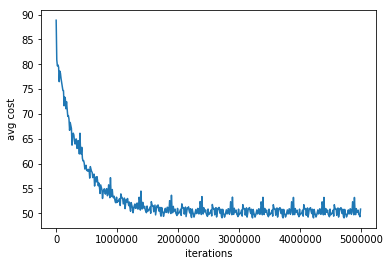

In [0]:
iterations = np.arange(len(cost_list))*10000
plt.plot(iterations,cost_list)
plt.xlabel("iterations")
plt.ylabel("avg cost")
plt.show()

Why do we see 10 regular "peaks" in the curve above? *(Hint: What did we fail to do at the start of each epoch?)*


**Challenge: Can you implement mini-batch SGD using the data and code above?** 